In [34]:
#Import packages

import pandas as pd
import datetime as dt
import statistics as stat
pd.set_option('display.max_rows', 800)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import StackingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [4]:
#Import data
my_dir = os.getcwd()

sample_submission = pd.read_csv(os.path.join(my_dir,'SampleSubmissionWiDS2021.csv'))
solution_template = pd.read_csv(os.path.join(my_dir,'SolutionTemplateWiDS2021.csv'))
data_dictionary = pd.read_csv(os.path.join(my_dir,'DataDictionaryWiDS2021.csv'))
unlabled_data = pd.read_csv(os.path.join(my_dir,'UnlabeledWiDS2021.csv'))
training_data = pd.read_csv(os.path.join(my_dir,'TrainingWiDS2021.csv'))

In [5]:
#View data
print(sample_submission.shape)
print(solution_template.shape)
print(data_dictionary.shape)
print(unlabled_data.shape)
print(training_data.shape)
print(training_data['diabetes_mellitus'].value_counts())

(3, 2)
(10234, 2)
(181, 6)
(10234, 180)
(130157, 181)
0    102006
1     28151
Name: diabetes_mellitus, dtype: int64


In [6]:
training_data.head(10)

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
1,2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,...,51.0,51.0,0,0,0,0,0,0,0,1
2,3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,...,NaN,NaN,0,0,0,0,0,0,0,0
3,4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,...,337.0,337.0,0,0,0,0,0,0,0,0
4,5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
5,6,182697,83,67.0,27.555611,0,Caucasian,M,190.5,Direct Admit,...,NaN,NaN,0,0,0,0,0,0,0,1
6,7,195124,83,59.0,57.451002,0,Caucasian,F,165.1,Operating Room,...,370.0,370.0,0,0,0,0,0,0,0,1
7,8,179261,33,70.0,NaN,0,Caucasian,M,165.0,Emergency Department,...,NaN,NaN,0,0,0,1,0,0,0,0
8,9,271041,118,45.0,NaN,0,Caucasian,M,170.2,Other Hospital,...,92.0,92.0,0,0,0,0,0,0,0,0
9,10,238874,118,50.0,25.707702,0,NaN,M,175.3,Direct Admit,...,NaN,NaN,0,0,0,0,0,0,0,0


# Data Cleaning

In [7]:
# Drop the column with no useful information
training_data.drop('Unnamed: 0', axis = 1, inplace = True)
unlabled_data.drop('Unnamed: 0', axis = 1, inplace = True)

### Missing values

In [8]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130157 entries, 0 to 130156
Columns: 180 entries, encounter_id to diabetes_mellitus
dtypes: float64(157), int64(17), object(6)
memory usage: 178.7+ MB


In [9]:
data_object=training_data.loc[:, training_data.dtypes == object]
data_object_un=unlabled_data.loc[:, unlabled_data.dtypes == object]

In [10]:
# Collect the list of all columns with missing values
column_na = training_data.columns[training_data.isna().any()].tolist()
column_na_un = unlabled_data.columns[unlabled_data.isna().any()].tolist()
column_na

['age',
 'bmi',
 'ethnicity',
 'gender',
 'height',
 'hospital_admit_source',
 'icu_admit_source',
 'weight',
 'albumin_apache',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'bilirubin_apache',
 'bun_apache',
 'creatinine_apache',
 'fio2_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'map_apache',
 'paco2_apache',
 'paco2_for_ph_apache',
 'pao2_apache',
 'ph_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'wbc_apache',
 'd1_diasbp_invasive_max',
 'd1_diasbp_invasive_min',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_invasive_max',
 'd1_mbp_invasive_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_invasive_max',
 '

In [11]:
# Preview some categorical clumns
data_object['gender'].unique()

array(['M', 'F', nan], dtype=object)

In [12]:
data_object['ethnicity'].unique()

array(['Caucasian', nan, 'Hispanic', 'African American', 'Asian',
       'Native American', 'Other/Unknown'], dtype=object)

In [13]:
data_object['icu_admit_source'].unique()

array(['Floor', 'Accident & Emergency', 'Operating Room / Recovery',
       'Other Hospital', 'Other ICU', nan], dtype=object)

In [14]:
data_object['hospital_admit_source'].unique()

array(['Floor', 'Emergency Department', 'Operating Room', nan,
       'Direct Admit', 'Other Hospital', 'Other ICU', 'ICU to SDU',
       'Recovery Room', 'Chest Pain Center', 'Step-Down Unit (SDU)',
       'Acute Care/Floor', 'PACU', 'Observation', 'ICU', 'Other'],
      dtype=object)

In [15]:
# Calculate the percentage of missing value in each column
per_na_l = []
for i in column_na:
    col_name = str(i)
    per_na = training_data[i].isnull().sum() * 100 / len(training_data) # get the percentage of NAs in each column
    per_na_l.append(per_na)
na_assess = pd.DataFrame(list(zip(column_na, per_na_l)), \
                         columns =['Variable Names', '% of NAs']).sort_values('% of NAs', ascending = False)


In [16]:
na_assess

,Variable Names,% of NAs
117,h1_bilirubin_min,92.089553
116,h1_bilirubin_max,92.089553
114,h1_albumin_max,91.431886
115,h1_albumin_min,91.431886
134,h1_lactate_max,91.018539
135,h1_lactate_min,91.018539
159,h1_pao2fio2ratio_min,87.123243
158,h1_pao2fio2ratio_max,87.123243
154,h1_arterial_ph_max,82.860699
155,h1_arterial_ph_min,82.860699


In [17]:
# For non-numeric columns
col_object = training_data.select_dtypes('object').columns.tolist()
col_object_un = unlabled_data.select_dtypes('object').columns.tolist()
col_object

['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_stay_type',
 'icu_type']

In [18]:
le = LabelEncoder()
for i in col_object:
    training_data[i].fillna("Not Specified",inplace = True)
    training_data[i] = le.fit_transform(training_data[i].astype(str))
    
for i in col_object_un:
    unlabled_data[i].fillna("Not Specified",inplace = True)
    unlabled_data[i] = le.fit_transform(unlabled_data[i].astype(str))

In [19]:
# For numeric columns
training_data.fillna(-9999,inplace = True)
unlabled_data.fillna(-9999,inplace = True)

### Evaluate correlations

In [20]:
train_corr = training_data.corr(method="pearson")
abs(train_corr["diabetes_mellitus"]) > 0.8
# No significant high correlation here

encounter_id                   False
hospital_id                    False
age                            False
bmi                            False
elective_surgery               False
ethnicity                      False
gender                         False
height                         False
hospital_admit_source          False
icu_admit_source               False
icu_id                         False
icu_stay_type                  False
icu_type                       False
pre_icu_los_days               False
readmission_status             False
weight                         False
albumin_apache                 False
apache_2_diagnosis             False
apache_3j_diagnosis            False
apache_post_operative          False
arf_apache                     False
bilirubin_apache               False
bun_apache                     False
creatinine_apache              False
fio2_apache                    False
gcs_eyes_apache                False
gcs_motor_apache               False
g

## Model 1: XGBoost

In [21]:
def roc_auc_plot(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

## Deal with imbalanced data

In [22]:
df_majority =training_data[training_data.diabetes_mellitus==0]
df_minority = training_data[training_data.diabetes_mellitus==1]

# upsample majority class
from sklearn.utils import resample

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=102006,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.diabetes_mellitus.value_counts()
# 1    576
# 0    576
# Name: balance, dtype: int64

1    102006
0    102006
Name: diabetes_mellitus, dtype: int64

In [23]:
X = df_upsampled.drop('diabetes_mellitus', axis = 1)
Y = df_upsampled['diabetes_mellitus']

In [24]:
# Splitting test and train data
seed = 123
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [25]:
# fit model with training data

xgb = XGBClassifier(
    max_depth = 5,
    subsample = 1,
    colsample_bytree = 0.7,
    colsample_bylevel = 0.7,
    scale_pos_weight = 1,
    min_child_weight = 1,
    reg_alpha = 4,
    n_jobs = 4, 
    objective = 'binary:logistic',
    nthread=4,
    gamma = 0.01,
    seed = 27,
)
xgb.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:08:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.01, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=4, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

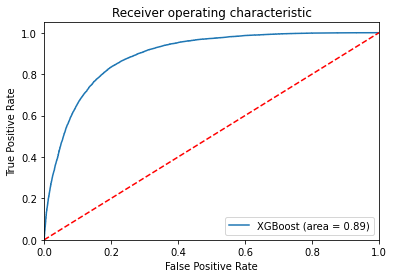

Accuracy: 81.7201%


In [26]:
# Predicting with test data
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
predictions = [round(value) for value in y_pred]
roc_auc = roc_auc_score(y_test, y_prob)
roc_auc_plot(fpr, tpr, roc_auc)

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.4f%%" % (accuracy * 100.0))

In [27]:
# Submission using XGBoost
y_sub=xgb.predict_proba(unlabled_data)[:,1]
y_sub

array([0.1587201 , 0.30283225, 0.23249829, ..., 0.20323166, 0.03167053,
       0.0235519 ], dtype=float32)

In [28]:
submission = unlabled_data[['encounter_id']]
submission['diabetes_mellitus'] = y_sub
submission = submission.sort_values('encounter_id')
submission.to_csv('winwin_submission.csv',index=False)

<ipython-input-28-aed3b1af4f6f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['diabetes_mellitus'] = y_sub


## Model 2: Random Forest

## Deal with imbalanced data

In [118]:
df_majority =training_data[training_data.diabetes_mellitus==0]
df_minority = training_data[training_data.diabetes_mellitus==1]

In [119]:
df_majority.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102006 entries, 2 to 130156
Columns: 180 entries, encounter_id to diabetes_mellitus
dtypes: float64(157), int64(23)
memory usage: 140.9 MB


In [120]:
# upsample majority class
from sklearn.utils import resample

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=102006,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.diabetes_mellitus.value_counts()
# 1    576
# 0    576
# Name: balance, dtype: int64

1    102006
0    102006
Name: diabetes_mellitus, dtype: int64

In [32]:
X=df_upsampled.drop('diabetes_mellitus', axis = 1)
y=df_upsampled['diabetes_mellitus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf=RandomForestClassifier(n_estimators=400, random_state = 42)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.933550094765048


In [35]:
CM=confusion_matrix(y_test, y_pred)

In [36]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9335988217661059

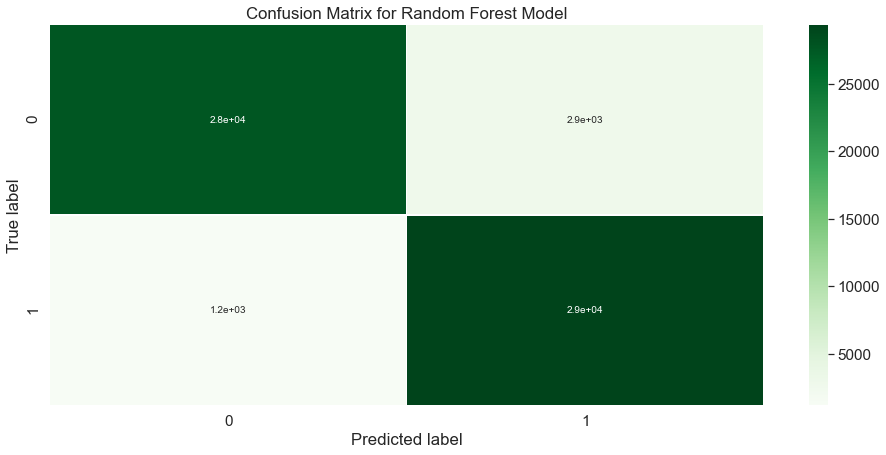

In [37]:
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(CM,annot=True,cmap=plt.cm.Greens,annot_kws={'size':10},linewidths=0.2)
class_names = [0,1]
tick_marks = np.arange(len(class_names))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93     30655
           1       0.91      0.96      0.94     30549

    accuracy                           0.93     61204
   macro avg       0.93      0.93      0.93     61204
weighted avg       0.93      0.93      0.93     61204



## Hyper parameter tuning

In [29]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

# Minimum number of samples required to split a node
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
# Minimum number of samples required at each leaf node
min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
from pprint import pprint
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5]),
 'min_samples_split': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000]}


In [35]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 53.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 99.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [36]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.2,
 'n_estimators': 733}

In [63]:
clf=RandomForestClassifier(n_estimators=733,min_samples_split=0.2,min_samples_leaf=0.1,max_features='auto',max_depth=10,bootstrap=False)

In [64]:
clf.fit(X_train,y_train)

#y_pred=clf.predict(X_test)

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=0.1,
                       min_samples_split=0.2, n_estimators=733)

In [34]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.72766485850598


In [65]:
# Submission using Random Forest
y_sub=clf.predict_proba(unlabled_data)[:,1]
y_sub

array([0.47778519, 0.37475451, 0.36386781, ..., 0.43320844, 0.30897436,
       0.31017527])

In [66]:
submission = unlabled_data[['encounter_id']]
submission['diabetes_mellitus'] = y_sub
submission = submission.sort_values('encounter_id')
submission.to_csv('winwin_submission.csv',index=False)

<ipython-input-66-aed3b1af4f6f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['diabetes_mellitus'] = y_sub
